In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix

2023-11-24 23:18:13.172263: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 300/300 [00:02<00:00, 113.85it/s]


(19795, 200, 200, 3)
(1311, 200, 200, 3)


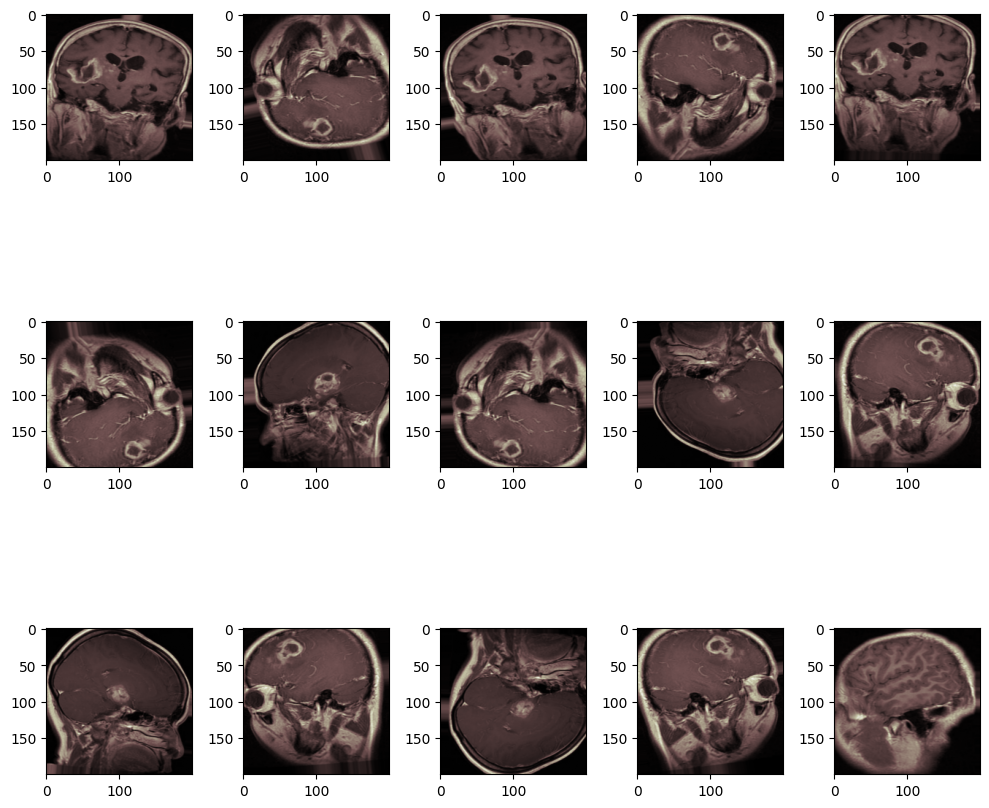

(1311, 200, 200, 3)
(19795, 200, 200, 3)
(1311, 4)
(19795, 4)


In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
net = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# 构建模型结构
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

# 编译模型
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

2023-11-24 23:21:16.579768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 23:21:16.895326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9


In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50


2023-11-24 23:21:29.586162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-11-24 23:21:30.217903: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-24 23:21:30.217935: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-11-24 23:21:30.218072: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-24 23:21:31.247615: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


495/495 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6694
Epoch 1: val_accuracy improved from inf to 0.99192, saving model to model-01-0.99-0.07.keras
495/495 [==============================] - 43s 75ms/step - loss: 0.7555 - accuracy: 0.6694 - val_loss: 0.0655 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 2/50
495/495 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9184
Epoch 2: val_accuracy improved from 0.99192 to 0.98283, saving model to model-02-0.98-0.09.keras
495/495 [==============================] - 35s 71ms/step - loss: 0.2323 - accuracy: 0.9184 - val_loss: 0.0937 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 3/50
495/495 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9537
Epoch 3: val_accuracy improved from 0.98283 to 0.96768, saving model to model-03-0.97-0.11.keras
495/495 [==============================] - 35s 71ms/step - loss: 0.1366 - accuracy: 0.9537 - val_loss: 0.1061 - val_accuracy: 0.9677 - l

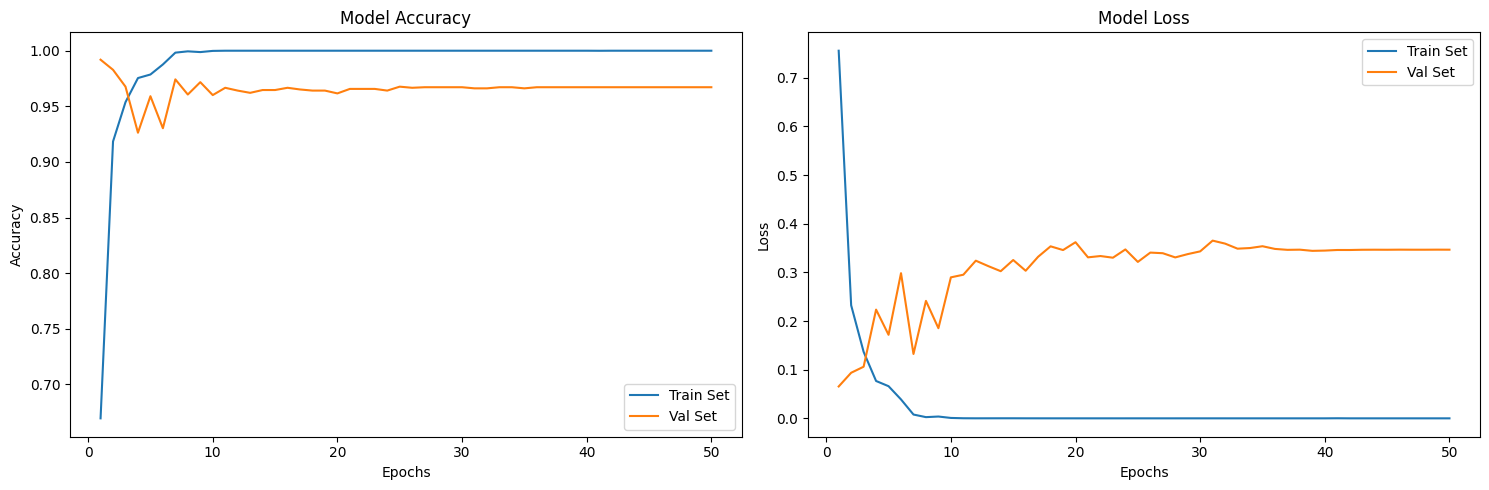

In [5]:
draw_curve(history)

41/41 [==============================] - 1s 23ms/step - loss: 0.1008 - accuracy: 0.9924
Test Accuracy:  99.24
              precision    recall  f1-score   support

      glioma     0.9966    0.9867    0.9916       300
  meningioma     0.9776    0.9967    0.9871       306
     notumor     0.9975    0.9975    0.9975       405
   pituitary     0.9966    0.9867    0.9916       300

    accuracy                         0.9924      1311
   macro avg     0.9921    0.9919    0.9920      1311
weighted avg     0.9925    0.9924    0.9924      1311



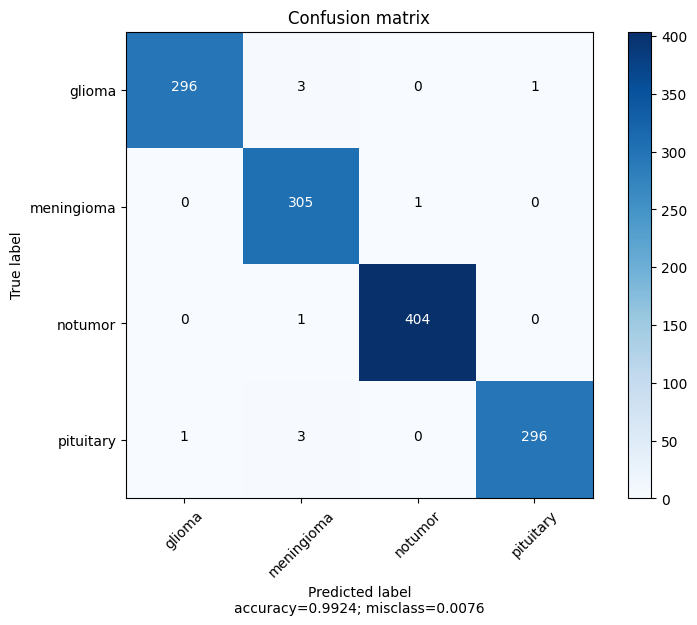

In [6]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)